## Fitting a model to a data cube

In this notebook, I am trying my hand at fitting a model to a (VLT) data cube. Obviously this will be tricky, as the data cubes have about 1 million pixels, multiple lines, continuum emission, and different noise distributions on different channels. Additionally, there are bad pixels and other artifacts that we'll have to deal with.

### 1. Fitting a gaussian cylinder
Let's begin by trying to fit a cylindrical Gaussian model in three dimensions. It will be constant across the third axis. This is equivalent to continuum emission extending through two spatial dimension and one spectral dimension.

In [1]:
import corner
from itertools import izip
import emcee
import numpy as np
import scipy.optimize as optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

%matplotlib inline

FWHM_TO_SIGMA = 1. / (2 * np.sqrt(2 * np.log(2.)))

RERUN_MCMC = False

In [ ]:
def gaussian_2d((ii, jj), amplitude, i_center, j_center, i_stddev, j_stddev, position_angle):
    """Given a set of coordinates and the 6 parameters of a 2d Gaussian, returns the 2d Gaussian
    image in (i,j) coordinates."""
    
    theta = (180 - position_angle) * np.pi / 180.
    
    a_ii = (np.cos(theta)**2)/(2*i_stddev**2) + (np.sin(theta)**2)/(2*j_stddev**2)
    b_ij = -(np.sin(2*theta))/(4*i_stddev**2) + (np.sin(2*theta))/(4*j_stddev**2)
    c_jj = (np.sin(theta)**2)/(2*i_stddev**2) + (np.cos(theta)**2)/(2*j_stddev**2)
    
    return amplitude * np.exp(-(a_ii*(ii-i_center)**2 + 2*b_ij*(ii-i_center)*(jj-j_center) \
                                + c_jj*(jj-j_center)**2)).T


# define the size of the 3d coordinate grid
N_k, N_i, N_j,  = (60, 128, 128)

# true parameters
true_params = [0.15, 45.67, 56.78, 5.5, 3.3, 40.]

ii, jj = np.meshgrid(xrange(N_i), xrange(N_j))
data = np.array([gaussian_2d((ii, jj), *true_params) for k in xrange(N_k)])

# sprinkle on some gaussian-distributed noise
data += np.random.normal(0, 0.02, data.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# plot along i=45
ax.plot_surface(*np.meshgrid(xrange(N_j), xrange(N_k)), Z=data[:, 45, :], cmap='coolwarm');

Let's now try to fit this with a simple model. We'll need to be careful with initial guesses, since that can drastically impact the performance of the fit. We will also try to estimate the noise profile.

In [ ]:
# try to estimate the centroid by finding the median i0, j0 based off center pixel locations
i0_init, j0_init = np.median([np.unravel_index(np.nanargmax(data[k]), (N_i, N_j)) for k in xrange(N_k)], axis=0)

# we could also try to estimate the standard deviations, but we'll skip that
amp_init = np.nanpercentile(data, 95.)
i_std_init, j_std_init = 5., 5.
position_angle_init = 45.

params_init = [amp_init, i0_init, j0_init, i_std_init, j_std_init, position_angle_init]

# define a 3d cylindrical model, raveled for the sake of curve_fit
def gaussian_cylindrical((ii, jj, N_k), *gaussian_2d_params):
    return np.array([gaussian_2d((ii, jj), *gaussian_2d_params) for k in xrange(N_k)]).ravel()

# use curve_fit to find optimized params
params_opt, params_cov = optimize.curve_fit(gaussian_cylindrical, (ii, jj, N_k), np.ravel(data), p0=params_init,
                            bounds=([0., 0., 0., 0., 0., -90.], [np.inf, N_i, N_j, np.inf, np.inf, 90.]))

model = np.array([gaussian_2d((ii, jj), *params_opt) for k in xrange(N_k)])

In [ ]:
# and plot now
fig, [ax, ax2] = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': '3d'})

ax.plot_surface(*np.meshgrid(xrange(N_j), xrange(N_k)), Z=data[:, 45, :], cmap='coolwarm')
ax.set_zlim(-0.05, 0.20)
ax.set_title('data')

ax2.plot_surface(*np.meshgrid(xrange(N_j), xrange(N_k)), Z=model[:, 45, :], cmap='coolwarm')
ax2.set_zlim(-0.05, 0.20)
ax2.set_title('model');

### Estimate data and model uncertainties

To find data uncertainties, I will try to fit the negative pixels *per channel* to a Gaussian distribution. This unfortunately does not capture the intrinsic scatter in the actual data. To find model uncertainties, I will use MCMC sampling via `emcee` to get maximum a posteri values and confidence intervals.

$$ \mathcal L = \prod_k p({\rm model \big|data}),$$
$$\ln \mathcal L = K - \sum_k \left( \frac{\big(y_k - g(x_k)\big )^2}{2\sigma_{yk}^2} \right ),$$
where $y_k$ are the data in each chanel $k$, $\sigma_{yk}$ are the uncertainties in each channel, and $g(x_k)$ are the model predictions for each of the pixels $x_k$ in the $k$th channel.

In [ ]:
def reject_outliers(x, num_std=3., c=0.67448975019608171):
    """Reject points in x that exceed some number of standard deviations by
    using the Median Absolute Deviation method, and assuming a conversion from 
    MADs to standard deviations of c."""
    return x[np.abs(x) < num_std / c * np.nanmedian(np.abs(x - np.nanmedian(x)))]

# find data uncertainties as a function of channel
data_uncertainties = np.array([np.nanstd(reject_outliers(channel, num_std=3)) for channel in data])

In [ ]:
# formulate in terms of likelihoods and chi-squared
def lnlike(theta, ii, jj, N_k, data, data_uncertainties):
    amplitude, i_center, j_center, i_stddev, j_stddev, position_angle = theta
    model = gaussian_2d((ii, jj), *theta) 
    return -0.5 * np.sum([(channel - model)**2 / sig_y**2 for channel, sig_y in izip(data, data_uncertainties)])

# use MCMC sampling to assign uncertainties...
nwalkers = 100
ndim = 6
nsteps = 500

# start walking from around the curve_fit optimized parameters
init_pos = [params_opt + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]


In [ ]:
# MCMC takes a while... show a progress bar
width = 80
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(ii, jj, N_k, data, data_uncertainties), threads=4)

if RERUN_MCMC:
    for i, result in enumerate(sampler.sample(init_pos, iterations=nsteps, rstate0=256)):
        n = int((width+1) * float(i) / nsteps)
        sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    sys.stdout.write("\n")

In [ ]:
if RERUN_MCMC:
    fig, axes = plt.subplots(6, 1, sharex=True, figsize=(8, 8))
    for i, [ax, param] in enumerate(zip(axes, ['$A$', '$i_0$', '$j_0$', '$\sigma_i$', '$\sigma_j$', r'$\theta_{pa}$'])):
        walkers = sampler.chain[:, :, i]
        for walker in walkers[::5]:
            ax.plot(xrange(nsteps), walker, lw=1.0, color='k', alpha=0.6)
        ax.set_ylabel(param)

    axes[5].set_yscale('log')
    axes[5].set_xlabel('Steps');

In [ ]:
if RERUN_MCMC:
    # burn-in sets in at ~100 steps
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

    # save temp file
    np.save('mcmc_cylinder_samples.npy', samples)
else:
    # load temp file
    samples = np.load('mcmc_cylinder_samples.npy')

In [ ]:
corner.corner(samples, labels=['$A$', '$i_0$', '$j_0$', '$\sigma_i$', '$\sigma_j$', r'$\theta_{pa}$'],
              truths=true_params);

That seemed to have worked quite well. Of note: my laptop took about 5 minutes to sample 500 steps with 100 walkers over 4 threads.

### 2. Fitting a power-law continuum

Now assume that there's some power-law slope in the spectrum, so that the amplitude is equal to the flux density $F_\lambda \propto \lambda^{-\alpha}$ divided by $2\pi \sigma_i \sigma_j$ (which can be found via integrating the volume under the $2d$ curve).

Our model now gains another free parameter, $\alpha$, and exchanges $A$ for $F_\nu$; together this brings the total number of model parameters to 7.

In [ ]:
def power_law_continuum((ii, jj, wavelength), f_lambda, alpha, i_center, j_center, i_stddev, j_stddev, position_angle):
    """Given two spatial coordinates and one spectral wavelength, the flux density and power law slope, and
    the five additional parameters of a 2d Gaussian, returns the 2d spatial Gaussian in (i,j) coordinates 
    at the given wavelength."""
    
    theta = (180 - position_angle) * np.pi / 180.
    
    a_ii = (np.cos(theta)**2)/(2*i_stddev**2) + (np.sin(theta)**2)/(2*j_stddev**2)
    b_ij = -(np.sin(2*theta))/(4*i_stddev**2) + (np.sin(2*theta))/(4*j_stddev**2)
    c_jj = (np.sin(theta)**2)/(2*i_stddev**2) + (np.cos(theta)**2)/(2*j_stddev**2)
    
    amplitude = f_lambda * np.power(wavelength, -alpha) / (2*np.pi*i_stddev*j_stddev)
    
    return amplitude * np.exp(-(a_ii*(ii-i_center)**2 + 2*b_ij*(ii-i_center)*(jj-j_center) \
                                + c_jj*(jj-j_center)**2)).T


# define the size of the 3d coordinate grid
N_k, N_i, N_j,  = (60, 128, 128)

# true parameters (now changing F_lambda=0.01, and adding alpha=1.5)
true_params = [50., 1.5, 45.67, 56.78, 5.5, 3.3, 40.]

# generate a wavelength range over N_k [um], otherwise power-law slope will be too steep
wavelengths = np.linspace(1.9, 2.2, N_k)

ii, jj = np.meshgrid(xrange(N_i), xrange(N_j))
data = np.array([power_law_continuum((ii, jj, wavelength), *true_params) for wavelength in wavelengths])

# sprinkle on some gaussian-distributed noise
data += np.random.normal(0, 0.02, data.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# plot along i=45
ax.plot_surface(*np.meshgrid(xrange(N_j), wavelengths), Z=data[:, 45, :], cmap='coolwarm');

In [ ]:
# time to estimate uncertainties as a function of channel
# as before, we reject > 3 sigma outliers
def reject_outliers(x, num_std=3., c=0.67448975019608171):
    return x[np.abs(x) < num_std / c * np.nanmedian(np.abs(x - np.nanmedian(x)))]

data_uncertainties = np.array([np.nanstd(reject_outliers(channel, num_std=3)) for channel in data])
data_uncertainties

In [ ]:
# again we try to estimate the centroid
i0_init, j0_init = np.median([np.unravel_index(np.nanargmax(data[k]), (N_i, N_j)) for k in xrange(N_k)], axis=0)

# and give our best shot at the rest of the parameters
alpha_init = -1.0
i_std_init, j_std_init = 5., 5.
f_lambda_init = np.nanpercentile(data, 95.) * (2*np.pi*i_std_init*j_std_init)
position_angle_init = 45.

params_init = [f_lambda_init, alpha_init, i0_init, j0_init, i_std_init, j_std_init, position_angle_init]

# define a raveled model
def continuum_model((ii, jj, wavelengths), *continuum_params):
    return np.array([power_law_continuum((ii, jj, wavelength), *continuum_params) \
                                      for wavelength in wavelengths])

def raveled_continuum_model((ii, jj, wavelengths), *continuum_params):
    return np.array([power_law_continuum((ii, jj, wavelength), *continuum_params) \
                                      for wavelength in wavelengths]).ravel()

# use curve_fit to find optimized params
params_opt, params_cov = optimize.curve_fit(raveled_continuum_model, (ii, jj, wavelengths), np.ravel(data), p0=params_init,
                    bounds=([0., -np.inf, 0., 0., 0., 0., -90.], [np.inf, np.inf, N_i, N_j, np.inf, np.inf, 90.]))

model = continuum_model((ii, jj, wavelengths), *params_opt).reshape(data.shape)

# plot this best-fit model
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(*np.meshgrid(xrange(N_j), wavelengths), Z=model[:, 45, :], cmap='coolwarm');

In [ ]:
# define a log-likelihood
def lnlike(theta, ii, jj, wavelengths, data, data_uncertainties):
    f_lambda, alpha, i_center, j_center, i_stddev, j_stddev, position_angle = theta
    model = continuum_model((ii, jj, wavelengths), *theta) 
    return -0.5 * np.sum([(y - model_slice)**2 / sig_y**2 \
                          for y, sig_y, model_slice in izip(data, data_uncertainties, model)])

# MCMC sample
nwalkers = 100
ndim = len(params_init)
nsteps = 400

init_pos = [params_opt + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
# run emcee
width = 80
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(ii, jj, wavelengths, data, data_uncertainties), 
                                threads=4)

if RERUN_MCMC:
    for i, result in enumerate(sampler.sample(init_pos, iterations=nsteps, rstate0=256)):
        n = int((width+1) * float(i) / nsteps)
        sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    sys.stdout.write("\n")

Note: this took about 12 minutes on my machine.

In [ ]:
if RERUN_MCMC:
    fig, axes = plt.subplots(7, 1, sharex=True, figsize=(8, 8))
    for i, [ax, param] in enumerate(zip(axes, ['$F_\lambda$', r'$\alpha$', '$i_0$', '$j_0$', '$\sigma_i$', '$\sigma_j$', r'$\theta_{pa}$'])):
        walkers = sampler.chain[:, :, i]
        for walker in walkers[::5]:
            ax.plot(xrange(nsteps), walker, lw=1.0, color='k', alpha=0.6)
        ax.set_ylabel(param)

    axes[6].set_yscale('log')
    axes[6].set_xlabel('Steps');

In [ ]:
if RERUN_MCMC:
    # let's chuck out the first ~150 steps due to burn-in
    samples = sampler.chain[:, 150:, :].reshape((-1, ndim))

    # save temp file
    np.save('mcmc_continuum_samples.npy', samples)
else:
    # load temp file
    samples = np.load('mcmc_continuum_samples.npy')
    
# or suppose we just care about true model parameters without the "nuissance" of figuring out centers, etc.
corner.corner(samples[:, :2], labels=['$F_\lambda$', r'$\alpha$'], truths=true_params[:2]);

### 3. Fitting a line + power-law continuum, with varied channel noise

Let's now assume that some channels might be especially noisy, and also that there's a Gaussian-profile line somewhere in the data cube. The Gaussian is parameterized by a FWHM line width $\Delta \lambda = 2\sqrt{2\ln 2}\sigma_{\rm line}$, line center, and line flux (which is related to the amplitude via $F = A\sqrt{2\pi\sigma_{\rm line}^2} = A\sqrt{\pi \Delta v / 4 \ln 2}$).

In [ ]:
FWHM_TO_SIGMA = 1. / (2 * np.sqrt(2 * np.log(2.)))

def brightness((ii, jj, wavelength), continuum_f_lambda, continuum_index, line_flux, line_center, line_width,
               i_center, j_center, i_stddev, j_stddev, position_angle):
    
    theta = (180 - position_angle) * np.pi / 180.
    
    a_ii = (np.cos(theta)**2)/(2*i_stddev**2) + (np.sin(theta)**2)/(2*j_stddev**2)
    b_ij = -(np.sin(2*theta))/(4*i_stddev**2) + (np.sin(2*theta))/(4*j_stddev**2)
    c_jj = (np.sin(theta)**2)/(2*i_stddev**2) + (np.cos(theta)**2)/(2*j_stddev**2)
    
    line_sigma = line_width * FWHM_TO_SIGMA
    
    continuum_flux_density = continuum_f_lambda*np.power(wavelength, -continuum_index) / (2*np.pi*i_stddev*j_stddev)
    
    line_flux_density = line_flux / np.sqrt(2*np.pi*line_sigma**2) * \
                               np.exp(-(wavelength-line_center)**2/(2*line_sigma**2))
    
    amplitude = continuum_flux_density + line_flux_density
    
    return amplitude * np.exp(-(a_ii*(ii-i_center)**2 + 2*b_ij*(ii-i_center)*(jj-j_center) \
                                + c_jj*(jj-j_center)**2)).T


# define the size of the 3d coordinate grid
N_k, N_i, N_j,  = (60, 128, 128)

# generate a wavelength range over N_k [um]
wavelengths = np.linspace(1.9, 2.2, N_k)

# true parameters (5 astrophysical model parameters + 5 parameters that shape the spatial Gaussian)
# note: I'll write line center and width in [um], and flux in the same units as the continuum * um
true_params = [50., 1.5, 0.06, 2.05, 0.03,
               45.67, 56.78, 5.5, 3.3, 40.]


ii, jj = np.meshgrid(xrange(N_i), xrange(N_j))
data = np.array([brightness((ii, jj, wavelength), *true_params) for wavelength in wavelengths])

# add some noise through cube
data += np.random.normal(0, 0.02, (N_k, N_i, N_j))

# and "other" noise
for k in [13, 28, 30, 31, 32, 35]:
    data[k] += np.random.normal(0, 0.40, (N_i, N_j))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# plot along i=45
ax.plot_surface(*np.meshgrid(xrange(N_j), wavelengths), Z=data[:, 45, :], cmap='coolwarm');

In [ ]:
data_uncertainties = np.array([np.nanstd(reject_outliers(channel, num_std=3)) for channel in data])
plt.scatter(wavelengths, data_uncertainties)
plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel(r'Estimated uncertainty');

Okay, it looks like we don't need to worry too much about the uncertainties. `MAD` does an excellent job of only sampling the noise.

In [ ]:
# spatial gaussian initial guesses
i0_init, j0_init = np.median([np.unravel_index(np.nanargmax(data[k]), (N_i, N_j)) for k in xrange(N_k)], axis=0)
i_std_init, j_std_init = 5., 5.
position_angle_init = 45.

# and give our best shot at the rest of the parameters
continuum_slope_init = -1.0
continuum_flux_density_init = np.nanpercentile(data, 90.) * (2*np.pi*i_std_init*j_std_init)
line_center_init = np.nanmedian(wavelengths)
line_width_init = 0.1 # [um]
line_flux_init = np.nanpercentile(data, 98.) * np.sqrt(2*np.pi)*line_width_init*FWHM_TO_SIGMA

params_init = [continuum_flux_density_init, continuum_slope_init, line_flux_init, line_center_init, line_width_init,
               i0_init, j0_init, i_std_init, j_std_init, position_angle_init]

def brightness_model((ii, jj, wavelengths), *brightness_params):
    return np.array([brightness((ii, jj, wavelength), *brightness_params) for wavelength in wavelengths])

def raveled_brightness_model((ii, jj, wavelengths), *brightness_params):
    return np.array([brightness((ii, jj, wavelength), *brightness_params) for wavelength in wavelengths]).ravel()

# use curve_fit to find optimized params
params_opt, params_cov = optimize.curve_fit(raveled_brightness_model, 
                                            (ii, jj, wavelengths), 
                                            np.ravel(data), 
                                            p0=params_init,
                                            bounds=([0., -np.inf, 0, min(wavelengths), 0., 0., 0., 0., 0., -90.], 
                                                    [np.inf, np.inf, np.inf, max(wavelengths), np.inf, N_i, N_j, np.inf, np.inf, 90.]))

model = brightness_model((ii, jj, wavelengths), *params_opt).reshape(data.shape)

In [ ]:
# plot model + residuals
fig, [ax, ax2] = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': '3d'})

ax.plot_surface(*np.meshgrid(xrange(N_j), wavelengths), Z=model[:, 45, :], cmap='coolwarm')
ax.set_zlim(0, 2.0)
ax.set_title('model')

ax2.plot_surface(*np.meshgrid(xrange(N_j), xrange(N_k)), Z=(data-model)[:, 45, :], cmap='coolwarm')
ax2.set_zlim(-1.0, 1.0)
ax2.set_title('residuals');

In [ ]:
# mcmc time

def lnlike(theta, ii, jj, wavelengths, data, data_uncertainties):
    cont_flux_density, cont_index, line_flux, line_center, line_width, \
                       i_center, j_center, i_stddev, j_stddev, position_angle = theta
    model = brightness_model((ii, jj, wavelengths), *theta) 
    return -0.5 * np.sum([(y - model_slice)**2 / sig_y**2 \
                          for y, sig_y, model_slice in izip(data, data_uncertainties, model)])

nwalkers = 100
ndim = len(params_init)
nsteps = 400

init_pos = [params_opt + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
# run emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, 
                                args=(ii, jj, wavelengths, data, data_uncertainties), 
                                threads=4)

if RERUN_MCMC:
    sampler.run_mcmc(pos0=init_pos, N=nsteps, rstate0=256)

Note: this took about 14 minutes on my machine.

In [ ]:
if RERUN_MCMC:
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(8, 8))
    for i, [ax, param] in enumerate(zip(axes, ['$F_\lambda$', r'$\alpha$', r'$F_{\rm line}$', '$\lambda_0$', '$\Delta\lambda$', '$i_0$', '$j_0$', '$\sigma_i$', '$\sigma_j$', r'$\theta_{pa}$'])):
        walkers = sampler.chain[:, :, i]
        for walker in walkers[::5]:
            ax.plot(xrange(nsteps), walker[:nsteps], lw=1.0, color='k', alpha=0.6)
        ax.set_ylabel(param)

    axes[9].set_yscale('log')
    axes[9].set_xlabel('Steps');

Okay, it doesn't look like we've properly burned in. Theta has only just converged, and the continuum model parameters have begun to branch out quite a bit.

In [ ]:
# run another 400 steps
if RERUN_MCMC:
    sampler.run_mcmc(pos0=None, N=nsteps, rstate0=256)

In [ ]:
if RERUN_MCMC:
    fig, axes = plt.subplots(10, 1, sharex=True, figsize=(8, 8))
    for i, [ax, param] in enumerate(zip(axes, ['$F_\lambda$', r'$\alpha$', r'$F_{\rm line}$', '$\lambda_0$', '$\Delta\lambda$', '$i_0$', '$j_0$', '$\sigma_i$', '$\sigma_j$', r'$\theta_{pa}$'])):
        walkers = sampler.chain[:, :, i]
        for walker in walkers[::5]:
            ax.plot(xrange(800), walker, lw=1.0, color='k', alpha=0.6)
        ax.set_ylabel(param)

    axes[9].set_yscale('log')
    axes[9].set_xlabel('Steps');

In [ ]:
# takes a few more steps to burn in, it seems.
# more steps might be needed to properly sample the continuum parameters (which have branched out a little more)
if RERUN_MCMC:
    samples = sampler.chain[:, 400:, :].reshape((-1, ndim))

    # save temp file
    np.save('mcmc_spectrum_samples.npy', samples)
else:
    # load temp file
    samples = np.load('mcmc_spectrum_samples.npy')
    
# corner plot
corner.corner(samples[:, :5], 
              labels=['$F_\lambda$', r'$\alpha$', r'$F_{\rm line}$', '$\lambda_0$', '$\Delta\lambda$'], 
              truths=true_params[:5]);

### 4. Fitting a spatially resolved source (and point source PSF) simultaneously

Let's assume that we want to jointly fit a PSF (or beam) *and* galaxy shape, both of which are 2d elliptical gaussians. We'll assume that we have a point-source calibration image as well.

In that case, we'd be jointly fitting a model to *two* data sets, one of the PSF image, and one of our spectral cube. The log-likelihood is simply the sum of each model's individual log-likelihood.

In order to quickly convolve the model with the PSF, we'll use the code from the [`Beam`](https://github.com/radio-astro-tools/radio_beam/blob/master/radio_beam/beam.py) class for analytic convolution (credit to authors of MIRIAD). Assuming PSF with major axis, minor axis, and position angle $(a_1, b_1, \theta_1)$, and source model with major axis, minor axis, and position angle $(a_2, b_2, \theta_2)$, then we define
$$ \alpha \equiv (a_1\cos\theta_1)^2 + (b_1\sin\theta_1)^2 + (a_2\cos\theta_2)^2 + (b_2\sin\theta_2)^2,$$
$$ \beta \equiv (a_1\sin\theta_1)^2 + (b_1\cos\theta_1)^2 + (a_2\sin\theta_2)^2 + (b_2\cos\theta_2)^2,$$
$$ \gamma \equiv (b_1^2 - a_1^2)\sin\theta_1\cos\theta_1 + (b_2^2 - a_2^2)\sin\theta_2\cos\theta_2, $$
$$ s \equiv \alpha + \beta, $$ 
$$ t \equiv \left ((\alpha - \beta)^2 + (2 \gamma)^2 \right )^{1/2},$$
from which we then compute the new parameters $a_f, b_f, \theta_f$:
$$ a_f = \left (\frac{s + t}{2} \right)^{1/2},$$
$$ b_f = \left (\frac{s - t}{2} \right)^{1/2},$$
$$ \theta_f = \frac{1}{2}\arctan\left(\frac{-2 \gamma}{\alpha - \beta}\right).$$

In [2]:
# convenience
DEGREE_TO_RADIAN = np.pi / 180.
cos, sin = np.cos, np.sin
sqrt = np.sqrt

# this is the 2d gaussian function from our simplest model
def gaussian_2d((ii, jj), amplitude, i_center, j_center, i_stddev, j_stddev, position_angle):
    theta = (180 - position_angle) * np.pi / 180.
    
    a_ii = (np.cos(theta)**2)/(2*i_stddev**2) + (np.sin(theta)**2)/(2*j_stddev**2)
    b_ij = -(np.sin(2*theta))/(4*i_stddev**2) + (np.sin(2*theta))/(4*j_stddev**2)
    c_jj = (np.sin(theta)**2)/(2*i_stddev**2) + (np.cos(theta)**2)/(2*j_stddev**2)
    
    return amplitude * np.exp(-(a_ii*(ii-i_center)**2 + 2*b_ij*(ii-i_center)*(jj-j_center) \
                                + c_jj*(jj-j_center)**2)).T

# now model a gaussian target, which will be then convolved with the PSF/beam
def brightness((ii, jj, wavelength), continuum_f_lambda, continuum_index, line_flux, line_center, line_width,
               i_center, j_center, i_stddev, j_stddev, position_angle, bmaj, bmin, bpa):
    """Note that the i,j_stdev are Gaussian sigma, whereas bmaj,bmin are FWHM. Also, both position angles
    should be in degrees north of west."""
    
    line_sigma = line_width * FWHM_TO_SIGMA
    
    continuum_flux_density = continuum_f_lambda*np.power(wavelength, -continuum_index) / (2*np.pi*i_stddev*j_stddev)
    line_flux_density = line_flux / np.sqrt(2*np.pi*line_sigma**2) * \
                               np.exp(-(wavelength-line_center)**2/(2*line_sigma**2))
    amplitude = continuum_flux_density + line_flux_density   
    
    alpha = ((bmaj*FWHM_TO_SIGMA*cos(bpa*DEGREE_TO_RADIAN))**2 +
             (bmin*FWHM_TO_SIGMA*sin(bpa*DEGREE_TO_RADIAN))**2 +
             (i_stddev*cos(position_angle*DEGREE_TO_RADIAN))**2 +
             (j_stddev*sin(position_angle*DEGREE_TO_RADIAN))**2)
    
    beta = ((bmaj*FWHM_TO_SIGMA*sin(bpa*DEGREE_TO_RADIAN))**2 +
            (bmin*FWHM_TO_SIGMA*cos(bpa*DEGREE_TO_RADIAN))**2 +
            (i_stddev*cos(position_angle*DEGREE_TO_RADIAN))**2 +
            (j_stddev*sin(position_angle*DEGREE_TO_RADIAN))**2)
    
    gamma = ((bmin**2-bmaj**2)*FWHM_TO_SIGMA**2 * sin(bpa*DEGREE_TO_RADIAN)*cos(bpa*DEGREE_TO_RADIAN) +
             (j_stddev**2-i_stddev**2) * sin(position_angle*DEGREE_TO_RADIAN)*cos(position_angle*DEGREE_TO_RADIAN))
        
    s = alpha + beta
    t = sqrt((alpha-beta)**2 + (2*gamma)**2)
        
    new_i_stddev = sqrt(0.5 * (s + t))
    new_j_stddev = sqrt(0.5 * (s - t))
    new_position_angle = 0.5 * np.arctan2(-2 * gamma, alpha - beta) / DEGREE_TO_RADIAN
    
    return gaussian_2d((ii, jj), amplitude, i_center, j_center, new_i_stddev, new_j_stddev, new_position_angle)

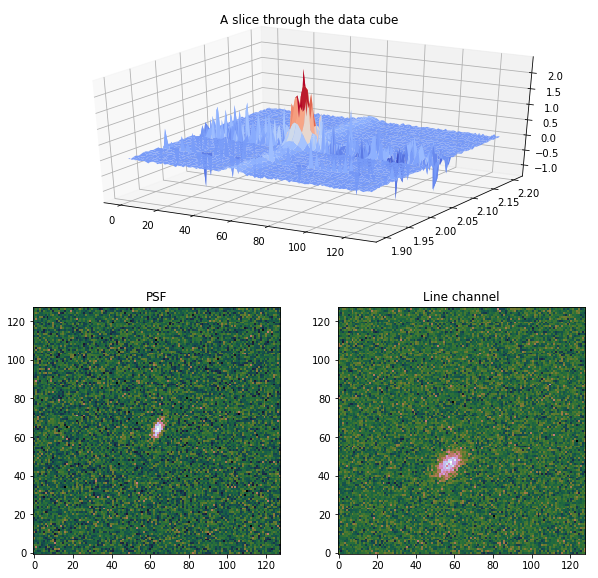

In [3]:
# define the size of the 3d coordinate grid
N_k, N_i, N_j,  = (60, 128, 128)

# generate a wavelength range over N_k [um]
wavelengths = np.linspace(1.9, 2.2, N_k)

# 5 model params, 5 spatial gaussian params, and now 3 PSF/beam params
true_params = [50., 1.5, 0.06, 2.05, 0.03,
               45.67, 56.78, 5.5, 3.3, 50.,
               3.5, 1.5, 25.]

ii, jj = np.meshgrid(xrange(N_i), xrange(N_j))
data = np.array([brightness((ii, jj, wavelength), *true_params) for wavelength in wavelengths])
psf_image = gaussian_2d((ii, jj), 
                        1/np.sqrt(2*np.pi*true_params[-3]*true_params[-2]), N_i/2., N_j/2., *true_params[-3:])

# add some noise through cube
data += np.random.normal(0, 0.02, (N_k, N_i, N_j))
for k in [13, 28, 30, 31, 32, 35]:
    data[k] += np.random.normal(0, 0.40, (N_i, N_j))

# let's add some noise to the PSF too, why not
psf_image += np.random.normal(0, 0.02, (N_i, N_j))
    
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot2grid((2, 2), (0, 0), colspan=2, projection='3d')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

# plot along i=45
ax.set_title('A slice through the data cube')
ax.plot_surface(*np.meshgrid(xrange(N_j), wavelengths), Z=data[:, 45, :], cmap='coolwarm');

# plot PSF
ax2.set_title('PSF')
ax2.imshow(psf_image, origin='lower', cmap='cubehelix');

# plot line channel
ax3.set_title('Line channel')
ax3.imshow(data[43], origin='lower', cmap='cubehelix');

In [46]:
def reject_outliers(x, num_std=3., c=0.67448975019608171):
    return x[np.abs(x) < num_std / c * np.nanmedian(np.abs(x - np.nanmedian(x)))]

# estimate uncertainties
data_uncertainties = np.array([np.nanstd(reject_outliers(channel, num_std=3)) for channel in data])
psf_uncertainty = np.nanstd(reject_outliers(psf_image, num_std=3))

# spatial gaussian initial guesses
i0_init, j0_init = np.median([np.unravel_index(np.nanargmax(data[k]), (N_i, N_j)) for k in xrange(N_k)], axis=0)
i_std_init, j_std_init = 5., 5.
position_angle_init = 30.

# psf parameter guesses
bmaj_init, bmin_init = 2., 2.
bpa_init = 60.

# and give our best shot at the rest of the parameters
continuum_index_init = 1.
init_beam_size = (np.pi*bmaj_init*bmin_init/(4*np.log(2.))) # units of pix
continuum_flux_density_init = np.nanmedian(np.nanmax(data, axis=(1, 2)) * (2*np.pi*i_std_init*j_std_init)) /\
                               np.power(wavelengths[0], -continuum_index_init)
line_center_init = wavelengths[np.nanargmax(np.nansum(data, axis=(1, 2)))]
line_width_init = 0.1 # [um]
line_flux_init = np.nanmax(data) * np.sqrt(2*np.pi)*line_width_init*FWHM_TO_SIGMA

In [22]:
params_init = [continuum_flux_density_init, continuum_index_init, line_flux_init, line_center_init, line_width_init,
               i0_init, j0_init, i_std_init, j_std_init, position_angle_init, bmaj_init, bmin_init, bpa_init]

inf = np.inf
bounds = np.array([[0., inf], [-inf, inf], [0., inf], [min(wavelengths), max(wavelengths)], [0., inf],
                   [0., N_i], [0., N_j], [0., inf], [0., inf], [-90., 90.], [0., inf], [0., inf], [-90., 90.]])

def psf_model((ii, jj), *psf_params):
    return gaussian_2d((ii, jj), 
                        1/np.sqrt(2*np.pi*psf_params[0]*psf_params[1]), len(ii)/2., len(jj)/2., *psf_params)

def brightness_model((ii, jj, wavelengths), *brightness_params):
    return np.array([brightness((ii, jj, wavelength), *brightness_params) for wavelength in wavelengths])

def raveled_brightness_model((ii, jj, wavelengths), *brightness_params):
    return np.array([brightness((ii, jj, wavelength), *brightness_params) for wavelength in wavelengths]).ravel()

# define likelihood, priors, probability, and chi^2
def lnlike(theta, ii, jj, wavelengths, data, data_uncertainties, psf_image, psf_uncertainty):
    # unpack all model params
    cont_flux_density, cont_index, line_flux, line_center, line_width, \
                       i_center, j_center, i_stddev, j_stddev, position_angle, \
                       bmaj, bmin, bpa = theta
    model_cube = brightness_model((ii, jj, wavelengths), *theta) 
    model_psf = psf_model((ii, jj), *theta[-3:])
    
    likelihood = -0.5 * (np.sum([(y - model_slice)**2 / sig_y**2 \
                             for y, sig_y, model_slice in izip(data, data_uncertainties, model_cube)]) +
                         np.sum((psf_image - model_psf)**2 / psf_uncertainty**2))
    return likelihood

# flat priors across a reasonable range
def lnprior(theta):
    cont_flux_density, cont_index, line_flux, line_center, line_width, \
                       i_center, j_center, i_stddev, j_stddev, position_angle, \
                       bmaj, bmin, bpa = theta
    
    if (0 < cont_index < 3) & (0 < line_width < 0.3) & (1. < i_std_init < 10.) & (1. < j_std_init < 10.) & \
    (bmaj > bmin) & (0 < bmaj < 5.) & (0 < bmin < 5.):
        return 0.
    return -np.inf
        
def lnprob(theta, *args):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, *args)

chi_squared = lambda *args: -1 * lnprob(*args)

In [14]:
# use optimize.minimize on chi^2 to find maximum a posteri
result_MAP = optimize.minimize(chi_squared, 
                               x0=params_init,
                               args=(ii, jj, wavelengths, data, data_uncertainties, psf_image, psf_uncertainty), 
                               bounds=bounds,
                               options={'disp': True})

params_opt = result_MAP['x'] if result_MAP['success'] else None0

model_cube = brightness_model((ii, jj, wavelengths), *params_opt).reshape(data.shape)
model_psf = psf_model((ii, jj), *params_opt[-3:]).reshape(psf_image.shape)

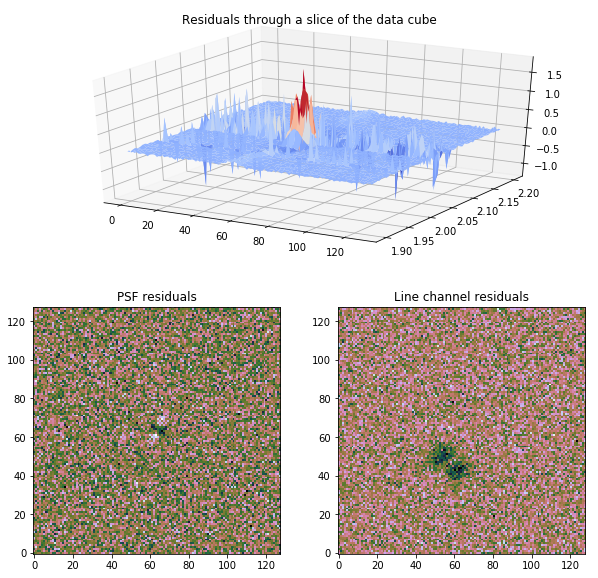

In [15]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot2grid((2, 2), (0, 0), colspan=2, projection='3d')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

# plot along i=45
ax.set_title('Residuals through a slice of the data cube')
ax.plot_surface(*np.meshgrid(xrange(N_j), wavelengths), Z=(data-model_cube)[:, 45, :], cmap='coolwarm');

# plot PSF
ax2.set_title('PSF residuals')
ax2.imshow(psf_image-model_psf, origin='lower', cmap='cubehelix');

# plot line channel
ax3.set_title('Line channel residuals')
ax3.imshow((data-model_cube)[43], origin='lower', cmap='cubehelix');

In [8]:
# compare chi^2 versus true parameter chi^2

optimized_chi2 = chi_squared(params_opt, ii, jj, wavelengths, data, data_uncertainties, psf_image, psf_uncertainty)
true_chi2 = chi_squared(true_params, ii, jj, wavelengths, data, data_uncertainties, psf_image, psf_uncertainty)

print('The optimized chi^2 is {:.2e} whereas the true chi^2 is {:.2e} (offset by some constant).'.format(optimized_chi2, true_chi2))

The optimized chi^2 is 7.46e+05 whereas the true chi^2 is 5.02e+05 (offset by some constant).


So clearly we're not converging on a proper solution. Perhaps if we just let MCMC walkers sample the space more, then we can see how long it will take for burn-in to bring us to a closer estimate. 

*Note: I'm not actually sure why minimizing the $\chi^2$ doesn't work, since we're using the [L-BFGS-B](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm and I think it should actually find the local minimum*.

In [29]:
nwalkers = 200
ndim = 13
nsteps = 500

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(ii, jj, wavelengths, data, data_uncertainties, psf_image, psf_uncertainty),
                                threads=4)

init_pos = [params_init + 0.01*np.random.randn(ndim) for i in range(nwalkers)]

In [30]:
RERUN_MCMC = True

if RERUN_MCMC:
    sampler.run_mcmc(pos0=init_pos, N=nsteps, rstate0=256)

In [31]:
# save output
if RERUN_MCMC:
    samples = sampler.chain.reshape((-1, ndim))

    # save temp file
    np.save('mcmc_psf+data_samples.npy', samples)
else:
    # load temp file
    samples = np.load('mcmc_psf+data_samples.npy')

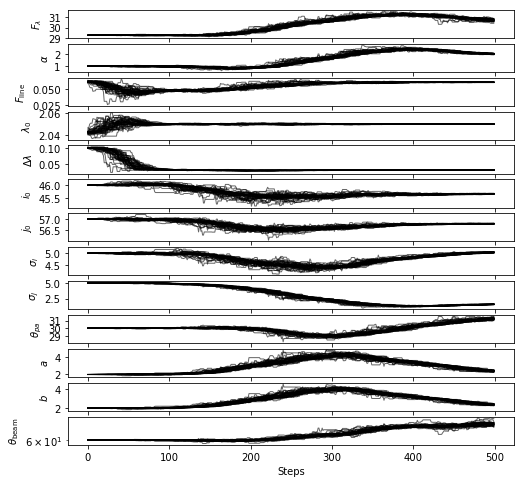

In [32]:
# visualize
if RERUN_MCMC:
    fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 8))
    for i, [ax, param] in enumerate(zip(axes, ['$F_\lambda$', r'$\alpha$', r'$F_{\rm line}$', '$\lambda_0$', '$\Delta\lambda$', 
                                               '$i_0$', '$j_0$', '$\sigma_i$', '$\sigma_j$', r'$\theta_{pa}$',
                                               '$a$', '$b$', r'$\theta_{\rm beam}$'])):
        walkers = sampler.chain[:, :, i]
        for walker in walkers[::5]:
            ax.plot(xrange(500), walker, lw=1.0, color='k', alpha=0.6)
        ax.set_ylabel(param)

    axes[ndim-1].set_yscale('log')
    axes[ndim-1].set_xlabel('Steps');

Still seems like it's not burned in. I might just use 4 walkers and walker for a few thousand steps...?

### 5. Fitting a spatially resolved source with a spectrum comprising a continuum + an unknown number of lines

### 6. Fitting an unknown number of sources that may be at different redshifts with the same spectra